In [1]:
import string
import re
import spacy 
import nltk
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

#To Temporarily Remove Deprecation Warning
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/CAMPUS/jrab2017/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/CAMPUS/jrab2017/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('/raid/tft-data/data/combined_news.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


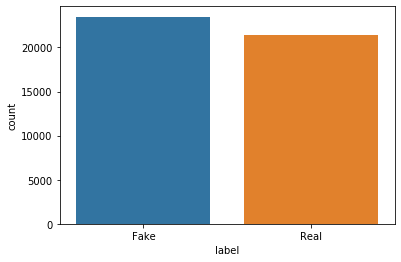

In [3]:
sns.countplot(data['label'])

count    44898.000000
mean       415.760412
std        361.648003
min          1.000000
25%        208.000000
50%        371.000000
75%        525.000000
max       8436.000000
Name: length, dtype: float64

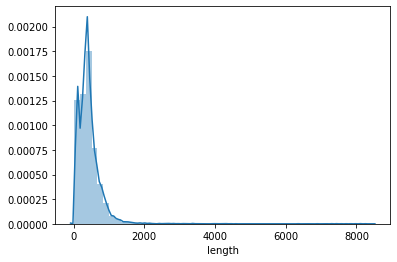

In [4]:
data['length'] = data['text'].apply(lambda x: len(x.split(' ')))
sns.distplot(data['length'])
data['length'].describe()

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
# main tokenizing function
def tokenize_line(line, chars_to_exclude, stopwords, tokenizer, stem_tokens=False, stemmer=None, lemm_tokens=False, lemmatizer=None):
    # removing unwanted characters and numbers from the string
    pattern = '[' + '|'.join(list(chars_to_exclude)) + '|\d]*'
    line = re.sub(pattern, "", line).lower()

    # generating tokens
    tokens = [token for token in tokenizer.tokenize(line) if token not in stopwords]
    
    # stemming the tokens if the user wants to
    if stem_tokens:
        tokens = [stemmer.stem(token) for token in tokens]

    # lemmatizing the tokens if the user wants to
    if lemm_tokens:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [7]:
# function to help with tokenizing columns
def tokenize_lines(lines, chars_to_exclude, stopwords, tokenizer=None, stem_tokens=False, stemmer=None, lemm_tokens=False, lemmatizer=None):

    all_tokens = [tokenize_line(line, chars_to_exclude, stopwords, tokenizer, stem_tokens, stemmer, lemm_tokens, lemmatizer) for line in lines]

    return np.array(all_tokens)

In [8]:
# the default parameters for now
def get_default_tokenization_params():
    chars_to_exclude = string.punctuation
    english_stopwords = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer("\w+")

    #Modify these according to the user's choices
    stem_tokens = False
    stemmer = PorterStemmer()

    lemm_tokens = True
    lemmatizer = WordNetLemmatizer()

    return (chars_to_exclude, english_stopwords, tokenizer, stem_tokens, stemmer, lemm_tokens, lemmatizer)

In [9]:

#To-Do: Brush up the following code to highlight the top topics discussed in the data sets: 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import pyLDAvis.sklearn

X = tokenize_lines(data['text'], *get_default_tokenization_params())
Y = data['label']
data_processed = pd.DataFrame(({'title': data['title'], 'text': X, 'label': Y}))


# Subsequent section attempts to perform some Topic Modeling using LDA 

# This section focuses on real news
real_news = data_processed[data_processed['label'] == 'Real']
num_topics = 10 
num_features = 100
'''
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0)
lda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])

pyLDAvis.enable_notebook()
data_vectorized = vectorizer.fit_transform(data_processed['text'])
dash = pyLDAvis.sklearn.prepare(lda_pipeline.steps[1][1], data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(dash, 'real_news_lda.html')

# Repeat the above for fake news

'''


/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


"\nvectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')\nlda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0)\nlda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])\n\npyLDAvis.enable_notebook()\ndata_vectorized = vectorizer.fit_transform(data_processed['text'])\ndash = pyLDAvis.sklearn.prepare(lda_pipeline.steps[1][1], data_vectorized, vectorizer, mds='tsne')\npyLDAvis.save_html(dash, 'real_news_lda.html')\n\n# Repeat the above for fake news\n\n"

In [10]:
realtext= real_news['text']

In [11]:
#Gensim library for additional topic modeling and statistical anlysis
#corpora module implements dictionary-mapping btwn words and corresponding int IDs
from gensim import corpora

real_gensim_dictionary = corpora.Dictionary(realtext)
#creating bag of words (bow) w/ realtext
real_gensim_corpus = [real_gensim_dictionary.doc2bow(token, allow_update=True) for token in realtext]

/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [12]:
import pickle
#saving dictionary and bow (via pickle )to use for predictions below
filename1 = 'real_gensim_corpus.pkl'
pickle.dump(real_gensim_corpus, open(filename1, 'wb'))
real_gensim_dictionary.save('real_gensim_dictionary.gensim')

In [13]:
import gensim
#creating LDA Model
#takes v long to load
real_lda_model = gensim.models.ldamodel.LdaModel(real_gensim_corpus, num_topics=num_topics, id2word=real_gensim_dictionary, passes=10)
real_lda_model.save('real_gensim_model.gensim')

In [14]:
#printing 5 words per topic
topics = real_lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.018*"said" + 0.017*"would" + 0.017*"republican" + 0.017*"tax" + 0.015*"house"')
(1, '0.024*"said" + 0.011*"state" + 0.010*"government" + 0.008*"force" + 0.008*"reuters"')
(2, '0.024*"said" + 0.020*"trump" + 0.011*"u" + 0.011*"president" + 0.009*"former"')
(3, '0.015*"said" + 0.015*"china" + 0.010*"company" + 0.008*"u" + 0.007*"year"')
(4, '0.030*"u" + 0.027*"said" + 0.020*"state" + 0.019*"trump" + 0.018*"united"')
(5, '0.018*"party" + 0.018*"trump" + 0.017*"election" + 0.016*"said" + 0.009*"percent"')
(6, '0.028*"said" + 0.010*"people" + 0.009*"reuters" + 0.008*"police" + 0.008*"year"')
(7, '0.032*"court" + 0.016*"said" + 0.012*"law" + 0.011*"government" + 0.011*"case"')
(8, '0.019*"said" + 0.012*"police" + 0.012*"state" + 0.012*"right" + 0.011*"people"')
(9, '0.019*"said" + 0.013*"north" + 0.013*"minister" + 0.011*"eu" + 0.011*"korea"')


In [15]:
#Evaluating LDA: Topic Coherence
#Perplexitiy: -8.169369315206076 (low)
#Coherence: 0.4601994449293338 (high)
#Perplexity is low and coherence is high which is expected as this is real news(?)

from gensim.models import CoherenceModel

coherence_score_lda = CoherenceModel(model=real_lda_model, texts=realtext, dictionary=real_gensim_dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nPerplexity:', real_lda_model.log_perplexity(real_gensim_corpus))
print('\nCoherence Score:', coherence_score)


Perplexity: -8.179862196999293

Coherence Score: 0.4350406721891159


In [16]:
#Topic Modeling Visualization

real_gensim_dictionary = gensim.corpora.Dictionary.load('real_gensim_dictionary.gensim')
real_gensim_corpus = pickle.load(open(filename1, 'rb'))
real_lda_model = gensim.models.ldamodel.LdaModel.load('real_gensim_model.gensim')

import pyLDAvis.gensim_models

lda_visualization = pyLDAvis.gensim_models.prepare(real_lda_model, real_gensim_corpus, real_gensim_dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_visualization)

/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [17]:
#Same as above but for fake news
fake_news = data_processed[data_processed['label'] == 'Fake']
faketext = fake_news['text']

In [18]:
fake_gensim_dictionary = corpora.Dictionary(faketext)
#creating bag of words (bow) w/ realtext
fake_gensim_corpus = [fake_gensim_dictionary.doc2bow(token, allow_update=True) for token in faketext]

#pickling useful for efficiently storing data to be used later
filename2 = 'fake_gensim_corpus.pkl'
pickle.dump(fake_gensim_corpus, open(filename2, 'wb'))
fake_gensim_dictionary.save('fake_gensim_dictionary.gensim')

In [19]:
fake_lda_model = gensim.models.ldamodel.LdaModel(fake_gensim_corpus, num_topics=num_topics, id2word=fake_gensim_dictionary, passes=10)
fake_lda_model.save('fake_gensim_model.gensim')

In [23]:
fake_topics = fake_lda_model.print_topics(num_words=5)
for fake_topic in fake_topics:
    print(fake_topic)

(0, '0.037*"trump" + 0.010*"president" + 0.009*"like" + 0.008*"people" + 0.008*"donald"')
(1, '0.040*"clinton" + 0.032*"hillary" + 0.021*"election" + 0.018*"trump" + 0.017*"campaign"')
(2, '0.011*"law" + 0.009*"muslim" + 0.009*"student" + 0.009*"state" + 0.008*"right"')
(3, '0.030*"black" + 0.019*"white" + 0.012*"american" + 0.012*"people" + 0.011*"protest"')
(4, '0.019*"medium" + 0.016*"news" + 0.015*"wire" + 0.010*"century" + 0.010*"st"')
(5, '0.011*"fbi" + 0.011*"clinton" + 0.010*"russian" + 0.009*"russia" + 0.009*"email"')
(6, '0.024*"u" + 0.010*"state" + 0.009*"syria" + 0.008*"obama" + 0.008*"war"')
(7, '0.010*"million" + 0.008*"year" + 0.008*"money" + 0.007*"state" + 0.007*"government"')
(8, '0.028*"republican" + 0.012*"democrat" + 0.012*"senator" + 0.012*"president" + 0.011*"senate"')
(9, '0.016*"police" + 0.013*"said" + 0.009*"year" + 0.008*"officer" + 0.006*"shooting"')


In [21]:
coherence_score_lda = CoherenceModel(model=fake_lda_model, texts= faketext, dictionary=fake_gensim_dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nPerplexity:', fake_lda_model.log_perplexity(fake_gensim_corpus))
print('\nCoherence Score:', coherence_score)


Perplexity: -9.07777888630131

Coherence Score: 0.47292858260469456


In [22]:
"""fake_gensim_dictionary = gensim.corpora.Dictionary.load('fake_gensim_dictionary.gensim')
fake_gensim_corpus = pickle.load(open(filename2, 'rb'))
fake_lda_model = gensim.models.ldamodel.LdaModel.load('fake_gensim_model.gensim')

import pyLDAvis.gensim_models

lda_visualization = pyLDAvis.gensim_models.prepare(fake_lda_model, fake_gensim_corpus, fake_gensim_dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_visualization)"""

"fake_gensim_dictionary = gensim.corpora.Dictionary.load('fake_gensim_dictionary.gensim')\nfake_gensim_corpus = pickle.load(open(filename2, 'rb'))\nfake_lda_model = gensim.models.ldamodel.LdaModel.load('fake_gensim_model.gensim')\n\nimport pyLDAvis.gensim_models\n\nlda_visualization = pyLDAvis.gensim_models.prepare(fake_lda_model, fake_gensim_corpus, fake_gensim_dictionary, sort_topics=False)\npyLDAvis.enable_notebook()\npyLDAvis.display(lda_visualization)"